In [1]:
import tensorflow as tf
import autobet.ocr_model as ocr_model
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

Using TensorFlow backend.


In [2]:
NUMBER_FONT = ImageFont.truetype('ChaletLondonNineteenSixty.ttf', 20)
LETTER_FONT = ImageFont.truetype('ChaletNewYorkNineteenSixty.ttf', 15)
TRAIN_DATASET_SIZE = 99_990
TEST_DATASET_SIZE = 19_980
TRAIN_PATH = 'training_data/train_images'
TEST_PATH = 'training_data/test_images'

BATCH_SIZE = 256

In [3]:
def generate_example(odd):
    rand_bg = tuple(random.randint(230, 255) for _ in range(3))
    img = Image.new('RGB', ocr_model.INPUT_SHAPE[:2], color=rand_bg)
    d = ImageDraw.Draw(img)
    rand_x = random.randint(10, 20)
    rand_y = random.randint(7, 15)
    rand_font_color = tuple(random.randint(0, 30) for _ in range(3))
    if odd != 1:
        d.text((rand_x,rand_y), f'{odd}/1', font=NUMBER_FONT, fill=rand_font_color)
    else:
        d.text((rand_x,rand_y), 'EVENS', font=LETTER_FONT, fill=rand_font_color)
    return img

In [4]:
# Generate datasets
for path in [TRAIN_PATH, TEST_PATH]:
    for odd in range(30):
        Path(f'{path}/{odd}').mkdir(parents=True, exist_ok=True)

for odd in tqdm(range(30)):
    for i in tqdm(range(TRAIN_DATASET_SIZE // 30), leave=False):
        example = generate_example(odd)
        example.save(f'{TRAIN_PATH}/{odd}/{i}.jpg')
    
for odd in tqdm(range(30)):
    for i in tqdm(range(TEST_DATASET_SIZE // 30), leave=False):
        example = generate_example(odd)
        example.save(f'{TEST_PATH}/{odd}/{i}.jpg')

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_dataset = image_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataset = image_generator.flow_from_directory(
    TEST_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 99990 images belonging to 30 classes.
Found 19980 images belonging to 30 classes.


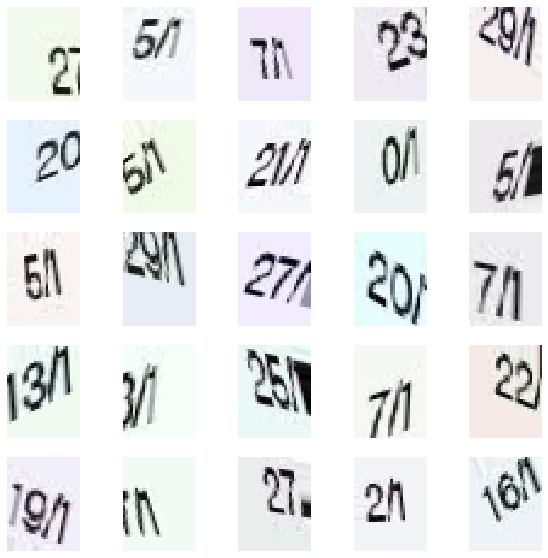

In [6]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

image_batch, label_batch = next(train_dataset)
show_batch(image_batch, label_batch)

In [7]:
model = ocr_model.model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 37, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 27, 64)        8256      
_________________________________________________________________
flatten (Flatten)            (None, 62208)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                995344    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1

In [10]:
model.fit_generator(train_dataset, epochs=10, verbose=1)

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
model.evaluate_generator(test_dataset, verbose=1)

In [ ]:
model.save(ocr_model.SAVED_MODEL_PATH)